# Frontera eficiente de Markowitz

Basado en un artículo de [towardsdatascience](https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5),
modificaciones por [Paduel](https://t.me/Paduel).

### Importa librerías y configura la visualización

In [1]:



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
from yfinance import download
import seaborn as sns
sns.set_theme()

### Selecciona los activos a considerar en la cartera y descarga datos

In [2]:
symbols = ["aapl", "csco", "msft", "amzn", "ibm", "aal", "ge", "mrna"]
start = "2018-01-01"
num_assets = len(symbols)

data = download(symbols, start=start)

[*********************100%***********************]  8 of 8 completed


In [3]:
stocks = data["Adj Close"]
log_ret=np.log(stocks/stocks.shift(1))

### Simulación por fuerza bruta

Simula 20.000 carteras aleatorias y selecciona aquella con mejor ratio de Sharpe

In [4]:
np.random.seed(42)
num_ports = 20000

all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(symbols)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]


In [5]:
# get the allocations in this max
weights_max_sim = pd.DataFrame(all_weights[sharpe_arr.argmax(), :], columns=[
                               "Weights %"], index=symbols).mul(100).round(2).T

print(f"Max Sharpe radio in the array. {sharpe_arr.max().round(2)}")
print(f"Its location in the array. {sharpe_arr.argmax()}")

display(weights_max_sim)

Max Sharpe radio in the array. 1.48
Its location in the array. 10008


,aapl,csco,msft,amzn,ibm,aal,ge,mrna
Weights %,2.81,28.95,21.39,1.2,0.3,2.86,26.8,15.7


### Visualiza las 20.000 simulaciones y la seleccionada

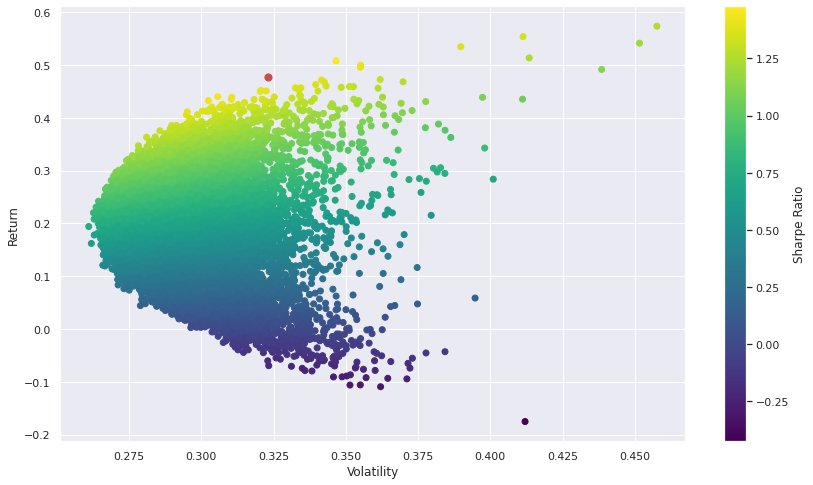

In [6]:
max_sr_ret= ret_arr[sharpe_arr.argmax()]
max_sr_vol= vol_arr[sharpe_arr.argmax()]
 
plt.figure(figsize=(14,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='r', s=50) # red dot
plt.show()

### Selecciona la cartera usando una función de optimización

In [7]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])


def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1


def check_sum(weights):
    # return 0 if sum of the weights is 1
    return np.sum(weights)-1

min_weight = 0
max_weight = 1

cons = ({'type': 'eq', 'fun': check_sum})
bounds = tuple([(min_weight, max_weight)] * num_assets)
init_guess = [1 / num_assets] * num_assets


opt_results = minimize(neg_sharpe, init_guess,
                       method='SLSQP', bounds=bounds, constraints=cons)
print(opt_results)

weights_opt = pd.DataFrame(opt_results.x, columns=["Weights %"], index=symbols).mul(100).round(2)
results_opt = pd.DataFrame(get_ret_vol_sr(opt_results.x), index=["Return", "Vola", "Sharpe"], columns=["Results"])
display(weights_opt.T)
display(results_opt.T)

     fun: -1.5683032073826844
     jac: array([ 1.73265813e+00,  9.56788659e-04,  1.38133764e-04,  5.87225616e-01,
        1.01470117e+00,  6.62438944e-01, -1.00278854e-03, -1.81794167e-06])
 message: 'Optimization terminated successfully'
    nfev: 94
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([9.55280131e-16, 2.63984207e-01, 3.03266753e-01, 0.00000000e+00,
       9.31784896e-17, 0.00000000e+00, 2.94391729e-01, 1.38357311e-01])


,aapl,csco,msft,amzn,ibm,aal,ge,mrna
Weights %,0.0,26.4,30.33,0.0,0.0,0.0,29.44,13.84


,Return,Vola,Sharpe
Results,0.53048,0.338251,1.568303


### Calcula la frontera optima para estos activos y la visualiza

In [8]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]


frontier_y = np.linspace(ret_arr.min(), ret_arr.max(), 200)

frontier_x = []

for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun': check_sum},
            {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})

    result = minimize(minimize_volatility, init_guess,
                      method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

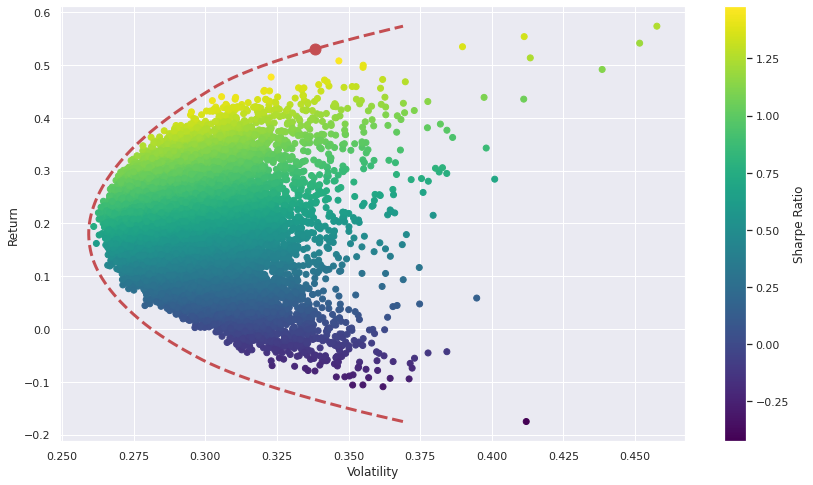

In [9]:
max_sr_ret= results_opt.loc["Return"]
max_sr_vol= results_opt.loc["Vola"]


plt.figure(figsize=(14,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.scatter(max_sr_vol, max_sr_ret,c='r', s=120) # red dot
#plt.savefig('cover.png')
plt.show()
 